In [ ]:
import pandas as pd
import re

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
import dotenv
import os

dotenv.load_dotenv()

True

In [2]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    code : Annotated[str, "Python Code"]
    messages : Annotated[list, add_messages]

In [3]:
def create_title_summary(df):

    df_sampled = df.sample(n=5000) if len(df) > 5000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""                                          
            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
            )
    
    chain = prompt | llm
    
    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")
    
    return title, summary

In [4]:
class Discriminator(BaseModel):
    """
    주어진 데이터와 관련이 있는 정보인지 판단하고 분석을 할 준비를 진행합니다.
    데이터와 관련이 있는 질문이라면 "yes", 기존 지식으로만 답변할 수 있다면 "no"라고 답변하세요.
    """

    binary : Literal["yes", "no"] = Field(..., description="""Determine if the information is relevant to the given data and prepare for analysis.
Answer "yes" if the questions are related to the data, and "no" if the questions can only be answered with existing knowledge.""")

In [5]:
class Judge(BaseModel):
    """
    당신은 AI에이전트입니다.
    가지고 있는 도구는 아래와 같습니다.

    1. PythonAstREPLTool : 텍스트로 된 파이썬 코드를 실행시킬 수 있는 도구

    입력된 값을 기준으로 판단했을 때 도구를 실행시켜야하는 경우라면 'tool', 코드를 실행시키지 않아도 되는 경우에는 'llm'이라고 답변하세요.
    """

    select_tool : Literal["tool", "llm"] = Field(..., description="""You are the assistant in charge of determining the execution of the tool.
Answer 'tool' if you need to run the code and 'llm' if you don't.""")

In [6]:
recent = ""

In [7]:
file_path = "./data/titanic.csv"
df = pd.read_csv(file_path)

llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})    

In [8]:
title, summary = create_title_summary(df)

===== 제목, 요약 생성 완료 =====




In [9]:
discriminator = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Discriminator)

judge = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0.,).with_structured_output(Judge)

In [10]:
def Discriminate(state:State):

    prompt = ChatPromptTemplate.from_messages([
        ("system","df : {df}"),
        ("human", "query : {query}")
    ])

    chain = prompt | discriminator

    result = chain.invoke({"df":df.head(),
                           "query":state["query"]}).binary
    
    global recent
    recent = result

    return result

In [11]:
def Judgement(state:State):

    prompt = ChatPromptTemplate.from_messages([
        ("system",""" 당신은 10년차 데이터 분석 전문가 및 해결사입니다.
                    질문의 결과를 위해 코드 실행이 필요한지 여부를 판단해야합니다.
                    그 판단을 위해 당신에겐 샘플 데이터가 주어집니다.
                    코드 실행이 필요하지 않다면 "llm"이라고 답변하세요.
                    하지만, 코드 실행을 해야한다면 "tool"을 반환합니다.
                    
                    ### 샘플 데이터
                    title : {title}
                    summary : {summary}
                    
                    df : {df}
                    ---

                """),
        ("human", "query : {query}")
    ])

    chain = prompt | judge

    result = chain.invoke({"title":title,
                            "summary":summary,
                            "df" : df.head(),
                            "query":state["query"]}).select_tool

    global recent
    recent = result

    return result

In [12]:
def create_code(state:State):
    
    prompt = ChatPromptTemplate([
        ("system", """당신은 pandas, matplotlib 라이브러리를 사용할 수 있는 전문가입니다. 주어진 df의 형태를 참고하여 코드를 작성합니다. \
                    다음은 `print(df.head())`의 형태입니다. {head}
        
                    ### 예시1
                    ```python
        
                    len(df)
                    ```
                    ### 예시2
                    ```python
        
                    # sum_gamerounds에 대한 히스토그램
                    plt.figure(figsize=(12, 6))
                    plt.barplot(df['sum_gamerounds'], bins=10, kde=True)
                    plt.title('Distribution of Sum Gamerounds')
                    plt.xlabel('Sum Gamerounds')
                    plt.ylabel('Frequency')
                    plt.grid()
                    plt.show()
                    ```
         
                    ### 주의할 점
                    1. seaborn은 사용하지 않습니다.
        
        """),
        ("human", "{query}")
    ])        
    
    chain = prompt | llm

    result = chain.invoke({
        "head" : df.head(),
        "query" : state["query"]
    }).content

    try:
        code = re.findall(r'```python\n(.*?)\n```', result, re.DOTALL)[0]

        return {"code" : code}
    except:
        return {"answer" : result,
                "code" : ""}

In [13]:
def execute_code(state:State):
    try:
        tool.invoke(state["code"])

        return state
    except:
        raise Exception("코드를 실행하지 못했습니다.")

In [ ]:
def response(state:State):

    if recent == "no":
        prompt = ChatPromptTemplate([
            ("system", """이전 대화 기록을 첨부합니다.
                          답변에 참고하세요.
                          history : {messages}"""),
            ("user", "{query}")

        ])

        chain = prompt | llm
        answer = chain.invoke({"messages":state["messages"],
                             "query":state["query"]})
        return {"answer":answer,
                "messages":[
                    HumanMessage(content=state["query"]), 
                    AIMessage(content=answer.content)
                    ]}
    elif recent == "llm":
        prompt = ChatPromptTemplate([
            ("system", """ 당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             데이터셋의 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             df : {df}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "df" : df,
            "query" : state["query"]
        })

        return {"answer" : chain.invoke({"title" : title,
                                         "summary" : summary,
                                         "df" : df,
                                         "query" : state["query"]
                                          }),
                                "messages":[
                    HumanMessage(content=state["query"]), 
                    AIMessage(content=answer.content)
                    ]}
    
    else:
        raise Exception("알 수 없는 응답입니다.")

In [15]:
def code_response(state:State):

    if state["code"] == "":
        prompt = ChatPromptTemplate([
            ("system", """ 당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             이전 답변과 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             답변 : {answer}
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "answer" : state["answer"],
            "query" : state["query"]
        })

        return {"answer" : answer, 
                "messages":[
                    HumanMessage(content=state["query"]), 
                    AIMessage(content=answer.content)
                    ]}

    else:
        prompt = ChatPromptTemplate([
            ("system", """당신은 주어진 시각화 차트를 해석하고 인사이트를 제공하는 데이터 분야 10년차 전문가입니다.
            
            친절하고 상세하게 해당 시각화 차트를 설명해주세요.
            단, 코드를 설명하는 것이 아닙니다.
            숫자를 물어본다면 정확한 숫자까지 이야기하세요.

            제목 : {title}
            요약 : {summary}

            코드 : {code}
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm
        
        answer = chain.invoke({
            "title" : title,
            "summary" : summary,
            "code" : state["code"],
            "query" : state["query"]
        })

        return {"answer" : answer,
                "messages":[
                    HumanMessage(content=state["query"]), 
                    AIMessage(content=answer.content)
                    ]}

In [16]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [17]:
def inter(state:State):
    return state

In [18]:
graph_builder = StateGraph(State)

In [19]:
graph_builder.add_node("inter", inter)
graph_builder.add_node("create_code", create_code)
graph_builder.add_node("execute_code", execute_code)
graph_builder.add_node("response", response)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("pretty_print", pretty_print)


graph_builder.add_conditional_edges(START,
                                    Discriminate,
                                    {
                                    "yes":"inter",
                                     "no":"response"
                                     }
                                     )
graph_builder.add_conditional_edges("inter",
                                    Judgement,
                                    {
                                    "tool":"create_code",
                                     "llm":"response"
                                     }
                                     )
graph_builder.add_edge("create_code", "execute_code")
graph_builder.add_edge("execute_code", "code_response")
graph_builder.add_edge("code_response", "pretty_print")
graph_builder.add_edge("response", "pretty_print")
graph_builder.add_edge("pretty_print", END);

In [20]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

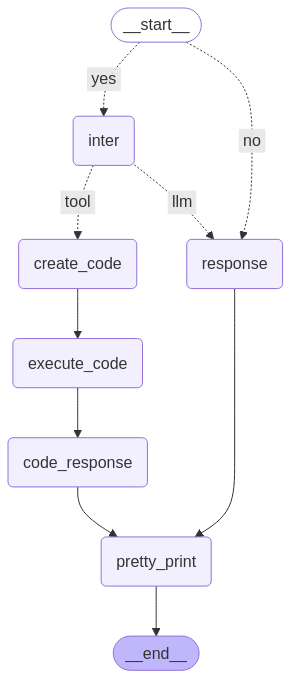

In [21]:
graph

In [22]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1054"})

In [23]:
events = graph.stream({"query": "생존자의 비율 시각화하고 인사이트 제공해줘."}, config=config)


[   inter   ]

{'query': '생존자의 비율 시각화하고 인사이트 제공해줘.', 'messages': []}

[   create_code   ]

{'code': 'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 생존자와 사망자 수 계산\nsurvived_counts = df[\'Survived\'].value_counts()\n\n# 생존자 비율 계산\nsurvived_ratio = survived_counts / survived_counts.sum()\n\n# 시각화\nplt.figure(figsize=(8, 6))\nplt.bar(survived_ratio.index, survived_ratio.values, color=[\'red\', \'green\'])\nplt.xticks(ticks=[0, 1], labels=[\'Not Survived\', \'Survived\'])\nplt.title(\'Survival Rate on the Titanic\')\nplt.xlabel(\'Survival Status\')\nplt.ylabel(\'Proportion\')\nplt.ylim(0, 1)\nplt.grid(axis=\'y\')\nplt.show()\n\n# 인사이트 제공\nprint(f"생존자 비율: {survived_ratio[1] * 100:.2f}%")\nprint(f"사망자 비율: {survived_ratio[0] * 100:.2f}%")'}


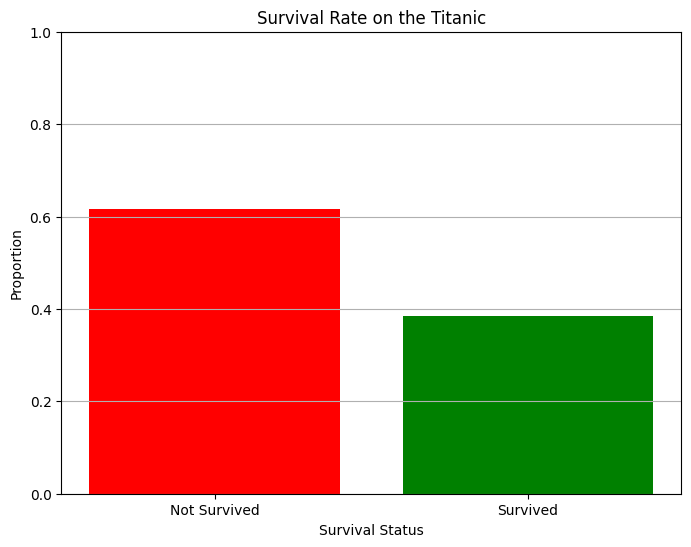

생존자 비율: 38.38%

[   execute_code   ]

{'query': '생존자의 비율 시각화하고 인사이트 제공해줘.', 'code': 'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 생존자와 사망자 수 계산\nsurvived_counts = df[\'Survived\'].value_counts()\n\n# 생존자 비율 계산\nsurvived_ratio = survived_counts / survived_counts.sum()\n\n# 시각화\nplt.figure(figsize=(8, 6))\nplt.bar(survived_ratio.index, survived_ratio.values, color=[\'red\', \'green\'])\nplt.xticks(ticks=[0, 1], labels=[\'Not Survived\', \'Survived\'])\nplt.title(\'Survival Rate on the Titanic\')\nplt.xlabel(\'Survival Status\')\nplt.ylabel(\'Proportion\')\nplt.ylim(0, 1)\nplt.grid(axis=\'y\')\nplt.show()\n\n# 인사이트 제공\nprint(f"생존자 비율: {survived_ratio[1] * 100:.2f}%")\nprint(f"사망자 비율: {survived_ratio[0] * 100:.2f}%")', 'messages': []}

[   code_response   ]

{'messages': [HumanMessage(content='생존자의 비율 시각화하고 인사이트 제공해줘.', additional_kwargs={}, response_metadata={}, id='f738c56e-7325-449e-a9e6-c2e4a951f13d'), AIMessage(content="제목: **타이타닉 생존자 비율 시각화**\n\n이 시각화는 타이타닉 호에서의 생존자와 사망자

In [24]:
for event in events:
    for k,v in event.items():
        print(f"\n[   {k}   ]\n")
        try:
            print(v)
        except:   
            pass

In [25]:
result = graph.invoke({"query":"아까 내가 질문했던 내용 다시 알려줘"}, config=config)



===== Result =====


당신이 아까 질문했던 내용은 "생존자의 비율 시각화하고 인사이트 제공해줘."였습니다. 이에 대한 답변으로 타이타닉 생존자 비율을 시각화하고, 생존자와 사망자의 비율에 대한 인사이트를 제공했습니다. 생존자의 비율은 약 38.38%로, 사망자의 비율은 약 61.62%라는 내용이 포함되어 있었습니다. 추가적인 정보나 질문이 필요하시면 말씀해 주세요!


In [26]:
result = graph.invoke({"query":"아까 물어봤던 숫자들 다 더하면 몇인지 알려줘"}, config=config)



===== Result =====


아까 언급된 숫자는 생존자 수 342명과 사망자 수 549명입니다. 이 두 숫자를 더하면:

342 + 549 = 891

따라서 총 승객 수는 891명입니다.


In [27]:
result = graph.invoke({"query":"아까 생존자 비율이 얼마라고 했지?"}, config=config)



===== Result =====


아까 생존자 비율은 약 38.38%라고 말씀드렸습니다. 추가적인 질문이 있으시면 언제든지 말씀해 주세요!
